# Tutorial: Digit classification using convolutional networks

In this notebook we will get familiar with the basics of Keras by trying to classify images of handwritten digits, which is known as the MNIST dataset. The images contain single digits (so numbers 0 to 9), meaning we have to do multiclass classification. 

This is a relatively simple task for us to do today, but was among the coolest problems you could work on in 1998. We will try out two different models -- first a plain feed-forward neural network, then one based on convolutions. 

This notebook is based on one of the Keras examples: https://keras.io/examples/vision/mnist_convnet/ Here you will find a lot on interesting examples of computer vision models -- many of them rather advanced. This one is, however, a nice starting point.

## Setup
Import the libraries we need.

In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt

c:\Users\Simon\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Simon\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
c:\Users\Simon\AppData\Local\Programs\Python\Python310\lib\site-packages\google\protobuf\runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framewo

## Load and prepare the data


In [2]:
# Ten classes (numbers 0 to 9)
num_classes = 10

# The images are 28x28 pixels, and have one channel (grayscale). 
# For color images, the last number here would be 3 (red/green/blue channel).
input_shape = (28, 28, 1)

# Load the data and split it between train and test sets
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()

# Scale images to the [0, 1] range
X_train = X_train.astype("float32") / 255
X_test = X_test.astype("float32") / 255

# Make sure images have shape (28, 28, 1)
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)
print("X_train shape:", X_train.shape)
print(X_train.shape[0], "train samples")
print(X_test.shape[0], "test samples")

# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
X_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Look at some of the data.

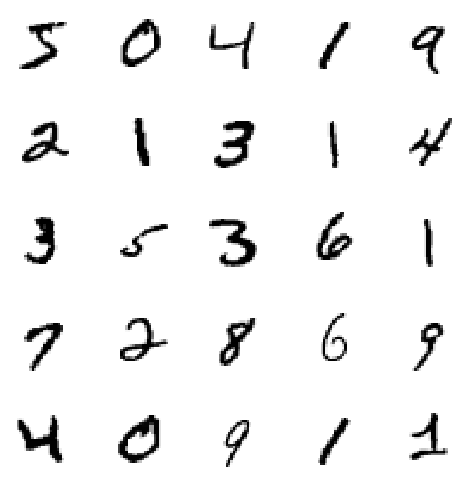

In [3]:
n_rows = 5
n_cols = 5
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

## Model number 1: A simple feed-forward network

This "multi-layer perceptron" tries to recognise patterns based on the value of each individual pixel, at its fixed position in the image.

First, we define the model and print it:

In [4]:
ff_network = keras.Sequential(
    [
        keras.layers.Input(shape=input_shape),
        keras.layers.Flatten(input_shape=[28, 28]),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dense(10, activation="softmax")
    ]
)

ff_network.summary()

c:\Users\Simon\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │        25,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           330 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26,506 (103.54 KB)

 Trainable params: 26,506 (103.54 KB)

 Non-trainable params: 0 (0.00 B)

Notice that we used the _sequential model API_: We made a list of layers and gave it as input to [`keras.Sequential`](https://keras.io/guides/sequential_model/). This is the most convenient way to create a model where each layer connects directly to the next. In case we need a more advanced layout of the model, we will have to use the _functional model API_, which we will look at later.

Next, we need to specify the loss function, the optimisation algorithm to use, and any metrics we want to measure during training. Since the classes (0-9) are evenly distributed, we choose to measure the accuracy.
"Compiling" the model configures it according to the given specification.

In [5]:
ff_network.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

Now we are ready to train the model:

In [6]:
batch_size = 128    # How many images to load in a single batch
epochs = 10         # How many times to iterate over the full dataset

ff_network.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8451 - loss: 0.5561 - val_accuracy: 0.9377 - val_loss: 0.2204
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9293 - loss: 0.2468 - val_accuracy: 0.9515 - val_loss: 0.1693
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9421 - loss: 0.1986 - val_accuracy: 0.9572 - val_loss: 0.1463
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9503 - loss: 0.1690 - val_accuracy: 0.9620 - val_loss: 0.1273
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9563 - loss: 0.1477 - val_accuracy: 0.9648 - val_loss: 0.1178
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9593 - loss: 0.1334 - val_accuracy: 0.9642 - val_loss: 0.1188
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9644 - loss: 0.1206 - val_accuracy: 0.9657 - val_loss: 0.1126
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9664 - loss: 0.1117 - val_accuracy: 0.

Let's evaluate the network on the test data:

In [7]:
score = ff_network.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.12680697441101074
Test accuracy: 0.9621999859809875


## A better network: The convolutional neural network (_convnet_)

Now let's construct a model based on convolutional and pooling layers.

In [8]:
convnet = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(0.4),
        keras.layers.Dense(num_classes, activation="softmax"),
    ]
)

convnet.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 11, 11, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 5, 5, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 800)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 10)             │         8,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,578 (68.66 KB)

 Trainable params: 17,578 (68.66 KB)

 Non-trainable params: 0 (0.00 B)

Compile and train it on the same data as before:

In [9]:
convnet.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

convnet.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.8673 - loss: 0.4327 - val_accuracy: 0.9757 - val_loss: 0.0916
Epoch 2/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9596 - loss: 0.1274 - val_accuracy: 0.9823 - val_loss: 0.0644
Epoch 3/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9699 - loss: 0.0988 - val_accuracy: 0.9865 - val_loss: 0.0541
Epoch 4/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9748 - loss: 0.0811 - val_accuracy: 0.9865 - val_loss: 0.0481
Epoch 5/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9777 - loss: 0.0721 - val_accuracy: 0.9877 - val_loss: 0.0447
Epoch 6/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9806 - loss: 0.0651 - val_accuracy: 0.9888 - val_loss: 0.0421
Epoch 7/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9813 - loss: 0.0591 - val_accuracy: 0.9897 - val_loss: 0.0380
Epoch 8/10
422/422 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.9827 - loss: 0.0552 - val_accuracy: 0.

And evaluate the results:

In [10]:
score = convnet.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.031767651438713074
Test accuracy: 0.9894000291824341


Notice how we made a smaller model (17k vs 26k number of parameters), but still got better results.